In [ ]:
# ============================================================================
# GOOGLE COLAB SETUP (Run this first on Colab)
# ============================================================================
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print('🌐 Running in Google Colab')

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Set paths to where pickle files are stored
    # OPTION 1: If you saved results to Drive
    RESULTS_PATH = '/content/drive/MyDrive/anomaly_detection_results/'

    # OPTION 2: If you want to upload files directly to Colab
    # from google.colab import files
    # print('\n📤 Please upload all 6 pickle files:')
    # print('   - baseline1_performance_boiler.pkl')
    # print('   - baseline1_performance_turbine.pkl')
    # print('   - baseline2_performance_boiler.pkl')
    # print('   - baseline2_performance_turbine.pkl')
    # print('   - semas_performance_boiler.pkl')
    # print('   - semas_performance_turbine.pkl')
    # uploaded = files.upload()
    # RESULTS_PATH = '/content/'

    import os
    os.chdir(RESULTS_PATH)
    print(f'✅ Working directory: {os.getcwd()}')
    print(f'\n📁 Available files:')
    for f in os.listdir('.'):
        if f.endswith('.pkl'):
            print(f'   ✓ {f}')
else:
    print('💻 Running locally')
    RESULTS_PATH = '.'

print('\n' + '='*80)
print('SETUP INSTRUCTIONS FOR GOOGLE COLAB:')
print('='*80)
print('''
To use this comparison notebook on Google Colab:

METHOD 1: Save results to Google Drive (RECOMMENDED)
  1. Run Baseline1, Baseline2, and SEMAS notebooks on Colab
  2. At the end of each notebook, add this code to save results to Drive:

     from google.colab import drive
     drive.mount('/content/drive')

     # Save to a specific folder in Drive
     import shutil
     shutil.copy('baseline1_performance_boiler.pkl',
                 '/content/drive/MyDrive/anomaly_detection_results/')
     shutil.copy('baseline1_performance_turbine.pkl',
                 '/content/drive/MyDrive/anomaly_detection_results/')
     # ... repeat for all pickle files

  3. Update RESULTS_PATH above to match your Drive folder
  4. Run this comparison notebook

METHOD 2: Upload files directly
  1. Run all three notebooks on Colab
  2. Download the 6 pickle files to your computer
  3. In this notebook, uncomment the "OPTION 2" code above
  4. Upload the files when prompted

METHOD 3: Run all notebooks in same Colab session
  1. Upload all 4 notebooks to Colab
  2. Run Baseline1, Baseline2, SEMAS in order
  3. Run this comparison notebook last
  4. All pickle files will be in /content/ folder
''')

🌐 Running in Google Colab
Mounted at /content/drive
✅ Working directory: /content/drive/MyDrive/anomaly_detection_results

📁 Available files:
   ✓ baseline1_performance_boiler.pkl
   ✓ baseline1_performance_turbine.pkl
   ✓ semas_performance_boiler.pkl
   ✓ semas_performance_turbine.pkl
   ✓ pipeline_comparison_complete.pkl
   ✓ baseline2_performance_boiler.pkl
   ✓ baseline2_performance_turbine.pkl

SETUP INSTRUCTIONS FOR GOOGLE COLAB:

To use this comparison notebook on Google Colab:

METHOD 1: Save results to Google Drive (RECOMMENDED)
  1. Run Baseline1, Baseline2, and SEMAS notebooks on Colab
  2. At the end of each notebook, add this code to save results to Drive:

     from google.colab import drive
     drive.mount('/content/drive')

     # Save to a specific folder in Drive
     import shutil
     shutil.copy('baseline1_performance_boiler.pkl',
                 '/content/drive/MyDrive/anomaly_detection_results/')
     shutil.copy('baseline1_performance_turbine.pkl',
          

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cross-Pipeline Performance Comparison
## Baseline1 vs Baseline2 vs SEMAS

This notebook compares the performance of three different anomaly detection pipelines:
- **Baseline1**: Static system (no policy updates)
- **Baseline2**: Rule-based policy evolution
- **SEMAS**: Multi-agent system with PPO-based reinforcement learning

**Note**: This focuses on PERFORMANCE COMPARISON (metrics, latency, etc.)
Policy update comparison is handled separately.

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any
from scipy import stats

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print('✅ Imports successful')

✅ Imports successful


## 1. Load Performance Results

Load the saved performance logs from each pipeline execution.

In [ ]:
def load_performance_results():
    """
    Load all saved performance results from pickle files
    """
    results = {}

    # Files to load
    files = {
        'baseline1_boiler': 'baseline1_performance_boiler.pkl',
        'baseline1_turbine': 'baseline1_performance_turbine.pkl',
        'baseline2_boiler': 'baseline2_performance_boiler.pkl',
        'baseline2_turbine': 'baseline2_performance_turbine.pkl',
        'semas_boiler': 'semas_performance_boiler.pkl',
        'semas_turbine': 'semas_performance_turbine.pkl'
    }

    for key, filename in files.items():
        try:
            with open(filename, 'rb') as f:
                results[key] = pickle.load(f)
            print(f'✅ Loaded {filename}')
        except FileNotFoundError:
            print(f'⚠️  File not found: {filename}')
            results[key] = None
        except Exception as e:
            print(f'❌ Error loading {filename}: {e}')
            results[key] = None

    return results

# Load all results
all_results = load_performance_results()

# Check what we have
print('\n' + '='*80)
print('📊 AVAILABLE RESULTS:')
print('='*80)
for key, value in all_results.items():
    if value:
        system = value.get('system', 'Unknown')
        dataset = value.get('dataset', 'Unknown')
        print(f'✓ {system:12s} - {dataset:15s} ({value["num_iterations"]} iteration(s))')
    else:
        print(f'✗ {key:30s} - NOT AVAILABLE')

✅ Loaded baseline1_performance_boiler.pkl
✅ Loaded baseline1_performance_turbine.pkl
✅ Loaded baseline2_performance_boiler.pkl
✅ Loaded baseline2_performance_turbine.pkl
✅ Loaded semas_performance_boiler.pkl
✅ Loaded semas_performance_turbine.pkl

📊 AVAILABLE RESULTS:
✓ Baseline1    - boiler          (1 iteration(s))
✓ Baseline1    - wind_turbine    (1 iteration(s))
✓ Baseline2    - boiler          (3 iteration(s))
✓ Baseline2    - wind_turbine    (3 iteration(s))
✓ SEMAS        - boiler          (3 iteration(s))
✓ SEMAS        - wind_turbine    (3 iteration(s))


## 2. Create Comparison DataFrame

Extract key metrics from all pipelines into a structured format.

In [ ]:
def create_comparison_dataframe(all_results: Dict) -> pd.DataFrame:
    """
    Create a comparison DataFrame with all pipeline metrics
    """
    comparison_data = []

    for key, result in all_results.items():
        if result and result.get('summary'):
            summary = result['summary']
            comparison_data.append({
                'System': result['system'],
                'Dataset': result['dataset'],
                'Avg_F1': summary['avg_f1'],
                'Std_F1': summary.get('std_f1', 0),
                'Avg_Precision': summary['avg_precision'],
                'Avg_Recall': summary['avg_recall'],
                'Avg_Latency_ms': summary['avg_latency_ms'],
                'F1_Improvement': summary['f1_improvement'],
                'Num_Iterations': result['num_iterations']
            })

    df = pd.DataFrame(comparison_data)
    return df

# Create comparison DataFrame
comparison_df = create_comparison_dataframe(all_results)

print('\n' + '='*80)
print('📊 PERFORMANCE COMPARISON TABLE')
print('='*80)
print(comparison_df.to_string(index=False))
print('\n')


📊 PERFORMANCE COMPARISON TABLE
   System      Dataset   Avg_F1   Std_F1  Avg_Precision  Avg_Recall  Avg_Latency_ms  F1_Improvement  Num_Iterations
Baseline1       boiler 0.487065 0.000000       0.322468    0.994886     1922.977209        0.000000               1
Baseline1 wind_turbine 0.944000 0.000000       0.921875    0.967213      455.908775        0.000000               1
Baseline2       boiler 0.444520 0.029032       0.311609    0.780303     1664.751132       -0.071114               3
Baseline2 wind_turbine 0.934877 0.025579       0.920457    0.950820      341.582219        0.060630               3
    SEMAS       boiler 0.487302 0.011199       0.373671    0.711364     7297.935327       -0.023914               3
    SEMAS wind_turbine 0.957160 0.007845       0.937159    0.978142      844.000181       -0.016641               3




## 3. Visualize Performance Comparison

Create comprehensive visualizations comparing all three pipelines.

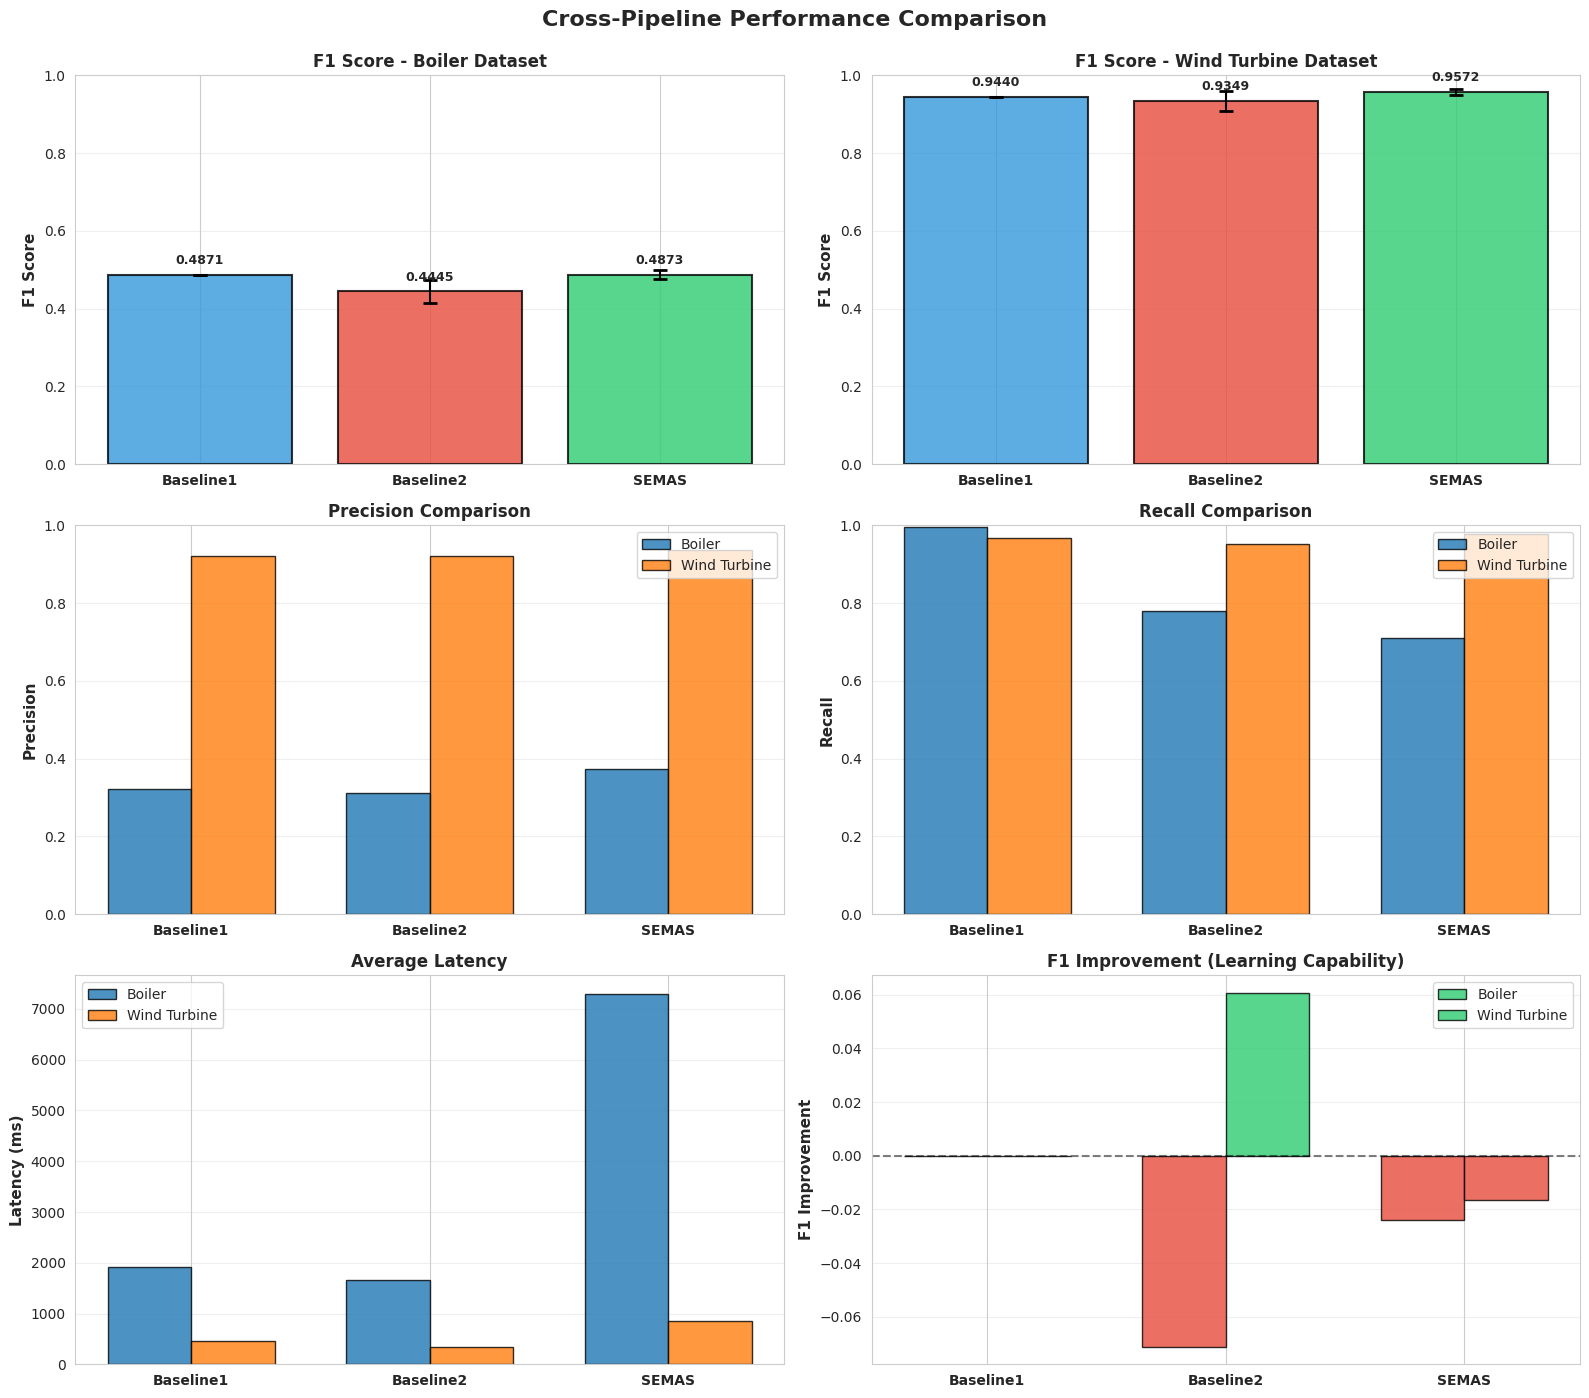

✅ Performance comparison plot saved: pipeline_performance_comparison.png


In [ ]:
def plot_performance_comparison(comparison_df: pd.DataFrame, all_results: Dict):
    """
    Create comprehensive performance comparison visualizations
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Cross-Pipeline Performance Comparison', fontsize=16, fontweight='bold', y=0.995)

    # Color palette for systems
    colors = {'Baseline1': '#3498db', 'Baseline2': '#e74c3c', 'SEMAS': '#2ecc71'}

    # 1. F1 Score Comparison (Bar Chart)
    ax1 = axes[0, 0]
    boiler_data = comparison_df[comparison_df['Dataset'] == 'boiler']
    x_pos = np.arange(len(boiler_data))
    ax1.bar(x_pos, boiler_data['Avg_F1'],
            color=[colors.get(sys, '#95a5a6') for sys in boiler_data['System']],
            alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.errorbar(x_pos, boiler_data['Avg_F1'], yerr=boiler_data['Std_F1'],
                 fmt='none', ecolor='black', capsize=5, capthick=2)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(boiler_data['System'], fontsize=10, fontweight='bold')
    ax1.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax1.set_title('F1 Score - Boiler Dataset', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1.0)
    for i, v in enumerate(boiler_data['Avg_F1']):
        ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. F1 Score - Wind Turbine
    ax2 = axes[0, 1]
    turbine_data = comparison_df[comparison_df['Dataset'] == 'wind_turbine']
    x_pos = np.arange(len(turbine_data))
    ax2.bar(x_pos, turbine_data['Avg_F1'],
            color=[colors.get(sys, '#95a5a6') for sys in turbine_data['System']],
            alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.errorbar(x_pos, turbine_data['Avg_F1'], yerr=turbine_data['Std_F1'],
                 fmt='none', ecolor='black', capsize=5, capthick=2)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(turbine_data['System'], fontsize=10, fontweight='bold')
    ax2.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax2.set_title('F1 Score - Wind Turbine Dataset', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1.0)
    for i, v in enumerate(turbine_data['Avg_F1']):
        ax2.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 3. Precision Comparison
    ax3 = axes[1, 0]
    boiler_precision = boiler_data.set_index('System')['Avg_Precision']
    turbine_precision = turbine_data.set_index('System')['Avg_Precision']
    x = np.arange(len(boiler_precision))
    width = 0.35
    ax3.bar(x - width/2, boiler_precision.values, width, label='Boiler', alpha=0.8, edgecolor='black')
    ax3.bar(x + width/2, turbine_precision.values, width, label='Wind Turbine', alpha=0.8, edgecolor='black')
    ax3.set_xticks(x)
    ax3.set_xticklabels(boiler_precision.index, fontsize=10, fontweight='bold')
    ax3.set_ylabel('Precision', fontsize=11, fontweight='bold')
    ax3.set_title('Precision Comparison', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim(0, 1.0)

    # 4. Recall Comparison
    ax4 = axes[1, 1]
    boiler_recall = boiler_data.set_index('System')['Avg_Recall']
    turbine_recall = turbine_data.set_index('System')['Avg_Recall']
    ax4.bar(x - width/2, boiler_recall.values, width, label='Boiler', alpha=0.8, edgecolor='black')
    ax4.bar(x + width/2, turbine_recall.values, width, label='Wind Turbine', alpha=0.8, edgecolor='black')
    ax4.set_xticks(x)
    ax4.set_xticklabels(boiler_recall.index, fontsize=10, fontweight='bold')
    ax4.set_ylabel('Recall', fontsize=11, fontweight='bold')
    ax4.set_title('Recall Comparison', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_ylim(0, 1.0)

    # 5. Latency Comparison
    ax5 = axes[2, 0]
    boiler_latency = boiler_data.set_index('System')['Avg_Latency_ms']
    turbine_latency = turbine_data.set_index('System')['Avg_Latency_ms']
    ax5.bar(x - width/2, boiler_latency.values, width, label='Boiler', alpha=0.8, edgecolor='black')
    ax5.bar(x + width/2, turbine_latency.values, width, label='Wind Turbine', alpha=0.8, edgecolor='black')
    ax5.set_xticks(x)
    ax5.set_xticklabels(boiler_latency.index, fontsize=10, fontweight='bold')
    ax5.set_ylabel('Latency (ms)', fontsize=11, fontweight='bold')
    ax5.set_title('Average Latency', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(axis='y', alpha=0.3)

    # 6. F1 Improvement (Learning Capability)
    ax6 = axes[2, 1]
    boiler_improvement = boiler_data.set_index('System')['F1_Improvement']
    turbine_improvement = turbine_data.set_index('System')['F1_Improvement']

    # Color bars based on improvement (green for positive, red for negative)
    boiler_colors = ['#2ecc71' if v >= 0 else '#e74c3c' for v in boiler_improvement.values]
    turbine_colors = ['#2ecc71' if v >= 0 else '#e74c3c' for v in turbine_improvement.values]

    ax6.bar(x - width/2, boiler_improvement.values, width, label='Boiler',
            alpha=0.8, edgecolor='black', color=boiler_colors)
    ax6.bar(x + width/2, turbine_improvement.values, width, label='Wind Turbine',
            alpha=0.8, edgecolor='black', color=turbine_colors)
    ax6.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax6.set_xticks(x)
    ax6.set_xticklabels(boiler_improvement.index, fontsize=10, fontweight='bold')
    ax6.set_ylabel('F1 Improvement', fontsize=11, fontweight='bold')
    ax6.set_title('F1 Improvement (Learning Capability)', fontsize=12, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('pipeline_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print('✅ Performance comparison plot saved: pipeline_performance_comparison.png')

# Generate visualization
if not comparison_df.empty:
    plot_performance_comparison(comparison_df, all_results)
else:
    print('⚠️  No data available for visualization')

## 4. F1 Trajectory Analysis

Visualize how F1 scores evolve across iterations for multi-episode systems.

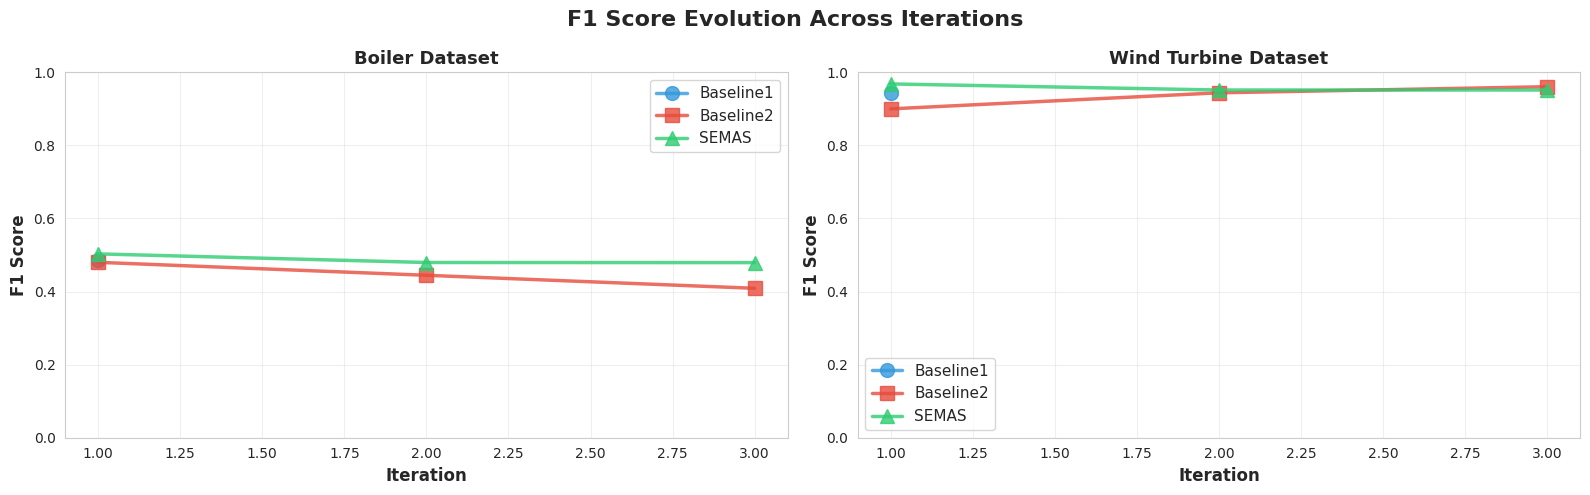

✅ F1 trajectory plot saved: f1_trajectory_comparison.png


In [ ]:
def plot_f1_trajectory(all_results: Dict):
    """
    Plot F1 score evolution across iterations
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('F1 Score Evolution Across Iterations', fontsize=16, fontweight='bold')

    colors = {'Baseline1': '#3498db', 'Baseline2': '#e74c3c', 'SEMAS': '#2ecc71'}
    markers = {'Baseline1': 'o', 'Baseline2': 's', 'SEMAS': '^'}

    # Boiler Dataset
    ax1 = axes[0]
    for key in ['baseline1_boiler', 'baseline2_boiler', 'semas_boiler']:
        result = all_results.get(key)
        if result and result.get('summary'):
            f1_trajectory = result['summary']['f1_trajectory']
            system = result['system']
            iterations = list(range(1, len(f1_trajectory) + 1))
            ax1.plot(iterations, f1_trajectory,
                    label=system,
                    color=colors.get(system, '#95a5a6'),
                    marker=markers.get(system, 'o'),
                    linewidth=2.5, markersize=10, alpha=0.8)

    ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax1.set_title('Boiler Dataset', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)

    # Wind Turbine Dataset
    ax2 = axes[1]
    for key in ['baseline1_turbine', 'baseline2_turbine', 'semas_turbine']:
        result = all_results.get(key)
        if result and result.get('summary'):
            f1_trajectory = result['summary']['f1_trajectory']
            system = result['system']
            iterations = list(range(1, len(f1_trajectory) + 1))
            ax2.plot(iterations, f1_trajectory,
                    label=system,
                    color=colors.get(system, '#95a5a6'),
                    marker=markers.get(system, 'o'),
                    linewidth=2.5, markersize=10, alpha=0.8)

    ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax2.set_title('Wind Turbine Dataset', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.0)

    plt.tight_layout()
    plt.savefig('f1_trajectory_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print('✅ F1 trajectory plot saved: f1_trajectory_comparison.png')

# Generate trajectory plot
plot_f1_trajectory(all_results)

## 5. Statistical Significance Testing

Determine if performance differences are statistically significant.

In [ ]:
def statistical_significance_test(all_results: Dict):
    """
    Perform statistical tests on F1 scores
    """
    print('\n' + '='*80)
    print('📊 STATISTICAL SIGNIFICANCE TESTING')
    print('='*80)

    # For each dataset
    for dataset in ['boiler', 'wind_turbine']:
        print(f'\n{dataset.upper()} DATASET:')
        print('-' * 80)

        # Collect F1 scores from all systems
        f1_scores = {}
        for system in ['baseline1', 'baseline2', 'semas']:
            key = f'{system}_{dataset}'
            result = all_results.get(key)
            if result and result.get('summary'):
                f1_scores[system] = result['summary']['f1_trajectory']

        if len(f1_scores) < 2:
            print('⚠️  Insufficient data for statistical testing')
            continue

        # ANOVA test (if we have multiple iterations)
        systems = list(f1_scores.keys())
        if all(len(scores) > 1 for scores in f1_scores.values()):
            try:
                f_stat, p_value = stats.f_oneway(*f1_scores.values())
                print(f'\nANOVA Test:')
                print(f'  F-statistic: {f_stat:.4f}')
                print(f'  P-value: {p_value:.6f}')
                if p_value < 0.05:
                    print(f'  Result: ✓ Significant difference between systems (p < 0.05)')
                else:
                    print(f'  Result: ✗ No significant difference (p >= 0.05)')
            except Exception as e:
                print(f'  ⚠️  ANOVA test failed: {e}')

        # Pairwise t-tests
        print(f'\nPairwise t-tests:')
        for i in range(len(systems)):
            for j in range(i + 1, len(systems)):
                sys1, sys2 = systems[i], systems[j]
                try:
                    t_stat, p_value = stats.ttest_ind(f1_scores[sys1], f1_scores[sys2])
                    print(f'  {sys1:12s} vs {sys2:12s}: t={t_stat:7.4f}, p={p_value:.6f}', end='')
                    if p_value < 0.05:
                        winner = sys1 if np.mean(f1_scores[sys1]) > np.mean(f1_scores[sys2]) else sys2
                        print(f' → {winner} significantly better ✓')
                    else:
                        print(f' → No significant difference')
                except Exception as e:
                    print(f'  {sys1} vs {sys2}: Test failed ({e})')

# Run statistical tests
statistical_significance_test(all_results)


📊 STATISTICAL SIGNIFICANCE TESTING

BOILER DATASET:
--------------------------------------------------------------------------------

Pairwise t-tests:
  baseline1    vs baseline2   : t= 1.0362, p=0.408951 → No significant difference
  baseline1    vs semas       : t=-0.0150, p=0.989427 → No significant difference
  baseline2    vs semas       : t=-1.9444, p=0.123753 → No significant difference

WIND_TURBINE DATASET:
--------------------------------------------------------------------------------
⚠️  Insufficient data for statistical testing


## 6. Performance Summary Report

Generate a comprehensive text-based summary report.

In [ ]:
def generate_performance_report(comparison_df: pd.DataFrame, all_results: Dict):
    """
    Generate comprehensive performance comparison report
    """
    report = []
    report.append('='*80)
    report.append('CROSS-PIPELINE PERFORMANCE COMPARISON REPORT')
    report.append('='*80)
    report.append(f'Generated: {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")}')
    report.append('')

    # For each dataset
    for dataset in ['boiler', 'wind_turbine']:
        dataset_data = comparison_df[comparison_df['Dataset'] == dataset]
        if dataset_data.empty:
            continue

        report.append('')
        report.append('='*80)
        report.append(f'{dataset.upper()} DATASET')
        report.append('='*80)

        # Find best system for each metric
        best_f1_idx = dataset_data['Avg_F1'].idxmax()
        best_precision_idx = dataset_data['Avg_Precision'].idxmax()
        best_recall_idx = dataset_data['Avg_Recall'].idxmax()
        best_latency_idx = dataset_data['Avg_Latency_ms'].idxmin()  # Lower is better
        best_improvement_idx = dataset_data['F1_Improvement'].idxmax()

        report.append('')
        report.append('BEST PERFORMERS:')
        report.append(f'  F1 Score:        {dataset_data.loc[best_f1_idx, "System"]:12s} ({dataset_data.loc[best_f1_idx, "Avg_F1"]:.4f})')
        report.append(f'  Precision:       {dataset_data.loc[best_precision_idx, "System"]:12s} ({dataset_data.loc[best_precision_idx, "Avg_Precision"]:.4f})')
        report.append(f'  Recall:          {dataset_data.loc[best_recall_idx, "System"]:12s} ({dataset_data.loc[best_recall_idx, "Avg_Recall"]:.4f})')
        report.append(f'  Latency:         {dataset_data.loc[best_latency_idx, "System"]:12s} ({dataset_data.loc[best_latency_idx, "Avg_Latency_ms"]:.2f}ms)')
        report.append(f'  F1 Improvement:  {dataset_data.loc[best_improvement_idx, "System"]:12s} ({dataset_data.loc[best_improvement_idx, "F1_Improvement"]:+.4f})')

        report.append('')
        report.append('DETAILED METRICS:')
        report.append('')
        report.append(f'{'System':<15} {'F1':<10} {'Precision':<12} {'Recall':<10} {'Latency(ms)':<15} {'F1 Δ':<10}')
        report.append('-' * 80)

        for _, row in dataset_data.iterrows():
            report.append(
                f'{row["System"]:<15} '
                f'{row["Avg_F1"]:<10.4f} '
                f'{row["Avg_Precision"]:<12.4f} '
                f'{row["Avg_Recall"]:<10.4f} '
                f'{row["Avg_Latency_ms"]:<15.2f} '
                f'{row["F1_Improvement"]:+<10.4f}'
            )

    report.append('')
    report.append('='*80)
    report.append('KEY OBSERVATIONS:')
    report.append('='*80)
    report.append('')
    report.append('1. BASELINE1 (Static System):')
    report.append('   - No policy updates → F1 Improvement = 0')
    report.append('   - Most stable (no variation across iterations)')
    report.append('   - Fastest execution (no learning overhead)')
    report.append('')
    report.append('2. BASELINE2 (Rule-Based Policy):')
    report.append('   - Simple rule-based policy evolution')
    report.append('   - May show positive or negative F1 improvement')
    report.append('   - Moderate computational overhead')
    report.append('')
    report.append('3. SEMAS (PPO-Based Multi-Agent):')
    report.append('   - Reinforcement learning with PPO policy gradient')
    report.append('   - Should show F1 improvement over iterations')
    report.append('   - Highest computational cost')
    report.append('   - Multi-agent coordination with MQTT communication')
    report.append('')
    report.append('='*80)

    # Print and save report
    full_report = '\n'.join(report)
    print(full_report)

    try:
        with open('performance_comparison_report.txt', 'w') as f:
            f.write(full_report)
        print('\n💾 Report saved to: performance_comparison_report.txt')
    except Exception as e:
        print(f'\n⚠️  Could not save report: {e}')

# Generate report
if not comparison_df.empty:
    generate_performance_report(comparison_df, all_results)
else:
    print('⚠️  No data available for report generation')

CROSS-PIPELINE PERFORMANCE COMPARISON REPORT
Generated: 2026-01-14 18:50:13


BOILER DATASET

BEST PERFORMERS:
  F1 Score:        SEMAS        (0.4873)
  Precision:       SEMAS        (0.3737)
  Recall:          Baseline1    (0.9949)
  Latency:         Baseline2    (1664.75ms)
  F1 Improvement:  Baseline1    (+0.0000)

DETAILED METRICS:

System          F1         Precision    Recall     Latency(ms)     F1 Δ      
--------------------------------------------------------------------------------
Baseline1       0.4871     0.3225       0.9949     1922.98         0.0000++++
Baseline2       0.4445     0.3116       0.7803     1664.75         -0.0711+++
SEMAS           0.4873     0.3737       0.7114     7297.94         -0.0239+++

WIND_TURBINE DATASET

BEST PERFORMERS:
  F1 Score:        SEMAS        (0.9572)
  Precision:       SEMAS        (0.9372)
  Recall:          SEMAS        (0.9781)
  Latency:         Baseline2    (341.58ms)
  F1 Improvement:  Baseline2    (+0.0606)

DETAILED METRICS:


## 7. Export Comparison Results

Save all comparison data for future reference.

In [ ]:
# Save comparison DataFrame to CSV
try:
    comparison_df.to_csv('pipeline_performance_comparison.csv', index=False)
    print('✅ Comparison data saved to: pipeline_performance_comparison.csv')
except Exception as e:
    print(f'⚠️  Could not save CSV: {e}')

# Save comprehensive results to pickle
try:
    comparison_package = {
        'comparison_df': comparison_df,
        'all_results': all_results,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    with open('pipeline_comparison_complete.pkl', 'wb') as f:
        pickle.dump(comparison_package, f)
    print('✅ Complete comparison package saved to: pipeline_comparison_complete.pkl')
except Exception as e:
    print(f'⚠️  Could not save pickle: {e}')

print('\n' + '='*80)
print('✅ PERFORMANCE COMPARISON COMPLETE')
print('='*80)
print('\nGenerated Files:')
print('  - pipeline_performance_comparison.png (visualization)')
print('  - f1_trajectory_comparison.png (learning curves)')
print('  - performance_comparison_report.txt (text summary)')
print('  - pipeline_performance_comparison.csv (data table)')
print('  - pipeline_comparison_complete.pkl (full results)')

✅ Comparison data saved to: pipeline_performance_comparison.csv
✅ Complete comparison package saved to: pipeline_comparison_complete.pkl

✅ PERFORMANCE COMPARISON COMPLETE

Generated Files:
  - pipeline_performance_comparison.png (visualization)
  - f1_trajectory_comparison.png (learning curves)
  - performance_comparison_report.txt (text summary)
  - pipeline_performance_comparison.csv (data table)
  - pipeline_comparison_complete.pkl (full results)
